<a href="https://colab.research.google.com/github/GermanOmar/UPS-termoelectrica/blob/master/IEEE_ETCM_UPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelado del proceso de producción de energía en centrales de generación térmica considerando el perfil de funcionamiento

<a href="https://ibb.co/0cmvG7t"><img src="https://i.ibb.co/XbjMCQ8/Motor-Combustion.png" WIDTH="550" HEIGHT="250"  border="0"></a>

 Libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings("ignore")

 Upload database:

In [2]:
!git clone https://github.com/GermanOmar/UPS-termoelectrica

Cloning into 'UPS-termoelectrica'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (9/9), done.


In [3]:
#Experimental data
data = pd.read_table('data.txt') 
data.describe()


,EN,HFO,DO,LO,R,D
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,1415.458986,81360.738904,9316.586301,390.683918,15.528603,83.863425
std,609.091448,38003.304182,6280.347503,473.592114,3.758765,15.000258
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,938.650000,49396.900000,5025.300000,65.780000,16.190000,79.320000
50%,1777.720000,101593.300000,8042.400000,249.790000,16.470000,88.580000
75%,1827.130000,109785.500000,12294.200000,546.510000,16.650000,91.340000
max,2034.310000,123914.700000,35895.400000,3234.090000,17.700000,97.110000


<a href="https://ibb.co/qnDpxjg"><img src="https://i.ibb.co/W3Hfs5z/Energia.png" WIDTH="700" HEIGHT="225"  border="0"></a>


Setting inputs - output:

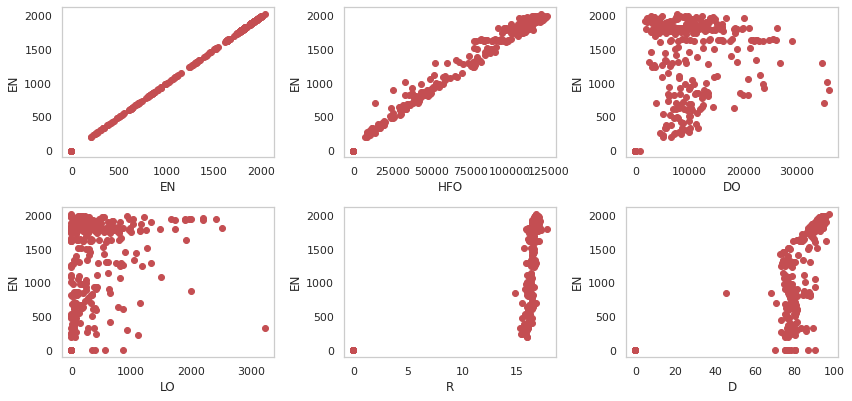

In [4]:
fields = [ 'EN', 'HFO','DO', 'LO','R', 'D']
import seaborn as sns
sns.set()
sns.set_theme(style="whitegrid")
plt.rcParams["axes.grid"] = False

fig = plt.figure()
fig.set_size_inches((12,8))
for i, field in enumerate(fields):
  plt.subplot(3, 3, i + 1)
  plt.plot(data[field], data['EN'], 'ro')
  plt.xlabel(field)
  plt.ylabel('EN')

plt.tight_layout()

X=data[[ 'HFO','DO', 'LO','R', 'D']]
Y=data['EN'][:,None]


#fig.tight_layout()

# Machine learning predictions

In [5]:
def normalize(X, X_mu, X_std):
  return (X - X_mu)/X_std

def denormalize(Xn, X_mu, X_std):
  return Xn*X_std + X_mu

X_std = X.std(0)
X_mu = X.mean(0)
Xn = normalize(X, X_mu, X_std)

Y_std = Y.std(0)
Y_mu = Y.mean(0)
Yn = normalize(Y, Y_mu, Y_std)

 Split data

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Xn, Yn, test_size=0.2, random_state=1234)
print('training samples:', X_train.shape[0],  ' test samples:', X_test.shape[0])

training samples: 292  test samples: 73


#Results:

###GBR 

In [7]:
from sklearn.ensemble import GradientBoostingRegressor
#KERNEL
#GBR=GradientBoostingRegressor(n_estimators=100, random_state=0)
GBR=GradientBoostingRegressor(n_estimators=2000, random_state=42, learning_rate=0.1 )

#START TRAINING
GBR.fit(X_train,y_train)
#PREDICTION
y_pred=GBR.predict(X_test)

#EVAL
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)

 
print("-Gradient boosting regressor-")
print("-----------------------------")

print('MSE test:', MSE_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()


-Gradient boosting regressor-
-----------------------------
MSE test: 0.006567522658277126

R2:  0.9935916820669487
RMSE:  0.08104025332066235
MAE:  0.048937955301951504
IM:  0.0948868413751032



### GPs

In [8]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
 
GP=GPR(kernel=kernel, n_restarts_optimizer=20, alpha=0.01, normalize_y=True)
 
#Training
GP.fit(X_train,y_train)
 
#Testing
y_star_train = GP.predict(X_train)
y_pred = GP.predict(X_test)
 
from sklearn.metrics import mean_squared_error
MSE_test = mean_squared_error(y_test, y_pred)
MSE_train = mean_squared_error(y_train, y_star_train)
 
print("Gaussian Process")
print('MSE train:', MSE_train)
print('MSE test:', MSE_test)
print("MSE train < MSE test?", MSE_train < MSE_test)
print()
from sklearn.metrics import r2_score
R2_train=r2_score(y_train, y_star_train)
print('R2_train: ',R2_train)
R2_test=r2_score(y_test, y_pred)
print('R2_test: ',R2_test)
print()
""" 
RE=100 * abs(y_test - y_pred) / y_test
print('Relative error (%): ',RE)
"""
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 
#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

Gaussian Process
MSE train: 0.0007977612316348554
MSE test: 0.0013609218725483246
MSE train < MSE test? True

R2_train:  0.9991940152277595
R2_test:  0.9986720685264265

R2:  0.9986720685264265
RMSE:  0.036890674601426365
MAE:  0.023574533932272743
IM:  0.043800044802154145



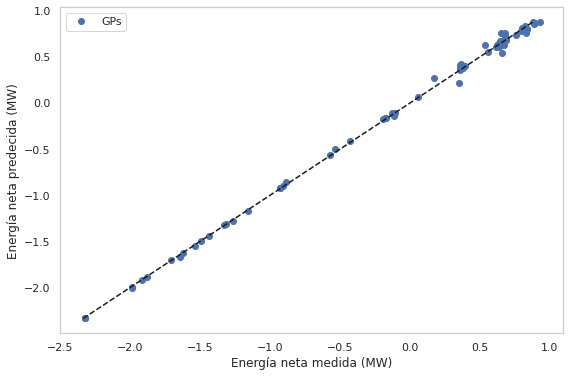

In [9]:
models = [   GP, ]
labels = [ 'GPs', ]

sns.set_theme(style="whitegrid")
plt.rcParams["axes.grid"] = False
fig = plt.figure()
fig.set_size_inches((9,6))

for mod, label in zip( models, labels): 
  y_pred = mod.predict(X_test)
  plt.plot(y_test, y_pred, 'o' ,label = label)

plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.ylabel('Energía neta predecida (MW)')
plt.xlabel('Energía neta medida (MW)')
plt.legend()  
  

### RFR

In [10]:
from sklearn.ensemble import RandomForestRegressor
#KERNEL
RFR=RandomForestRegressor(n_estimators=2000,max_depth=20)

#START TRAINING
RFR.fit(X_train,y_train)
#PREDICTION
y_pred=RFR.predict(X_test)

#EVAL
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)

print("-----------------------------")

print('MSE test:', MSE_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

-----------------------------
MSE test: 0.0117108588885615

R2:  0.9885730265532592
RMSE:  0.1082167218527779
MAE:  0.06390442802196962
IM:  0.12619512879477207



### XGB

In [11]:
import pickle
import xgboost as xgb

xgbr = xgb.XGBRegressor(verbosity=0, n_estimators=2000, max_depth=20)
xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_test)

In [12]:
print(xgbr)



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=20, min_child_weight=1, missing=None, n_estimators=2000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=0)


In [13]:
score = xgbr.score(X_test, y_test)  
print("Training score: ", score)

Training score:  0.9923647782482805


In [14]:
print("-XGBRegressor -")
print("------------------")

#EVAL
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)

print('MSE test:', MSE_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

-XGBRegressor -
------------------
MSE test: 0.007824907000441528

R2:  0.9923647782482805
RMSE:  0.08845850439862482
MAE:  0.05381922743321681
IM:  0.10382539599321436



Feature importance

Feature: 0, Score: 0.96444
Feature: 1, Score: 0.02196
Feature: 2, Score: 0.00050
Feature: 3, Score: 0.00186
Feature: 4, Score: 0.01123


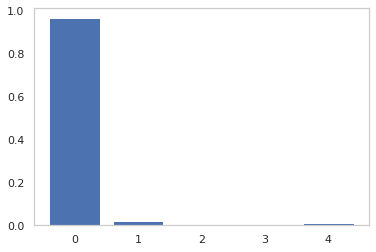

In [15]:
# get importance
importance = xgbr.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

### MLP

In [16]:
from sklearn.neural_network import MLPRegressor

MLP = MLPRegressor(hidden_layer_sizes=5,solver='lbfgs',learning_rate='adaptive',activation='relu',random_state=32, max_iter=2000)
#MLP = MLPRegressor(hidden_layer_sizes=(1000,1000,1000), activation='relu', solver='adam', max_iter=800)

#START TRAINING
MLP.fit(X_train,y_train)
#PREDICTION
y_pred=MLP.predict(X_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()



R2:  0.9998871092410416
RMSE:  0.08845850439862482
MAE:  0.007529521834960481
IM:  0.08877845146108446



### Linear SVR

In [17]:
from sklearn.svm import LinearSVR

SVR=LinearSVR( random_state=32)

#START TRAINING
SVR.fit(X_train,y_train)
#PREDICTION
y_pred=SVR.predict(X_test)
print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()



R2:  0.99849485424719
RMSE:  0.08845850439862482
MAE:  0.025742352282326367
IM:  0.09214033408451547



# Comparisson

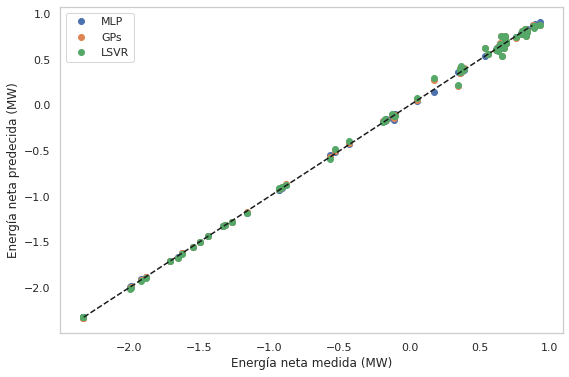

In [18]:
models = [ MLP ,  GP, SVR]
labels = ['MLP', 'GPs', 'LSVR']

sns.set_theme(style="whitegrid")
plt.rcParams["axes.grid"] = False
fig = plt.figure()
fig.set_size_inches((9,6))

for mod, label in zip( models, labels): 
  y_pred = mod.predict(X_test)
  plt.plot(y_test, y_pred, 'o' ,label = label)

plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.ylabel('Energía neta predecida (MW)')
plt.xlabel('Energía neta medida (MW)')
plt.legend()  
  

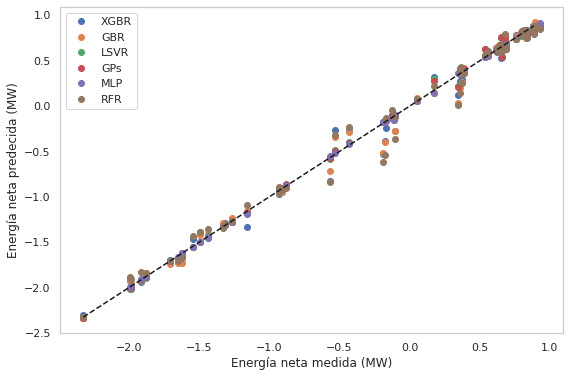

In [19]:
models = [xgbr,  GBR, SVR, GP, MLP, RFR ]
labels = ['XGBR',  'GBR', 'LSVR',  'GPs',  'MLP', 'RFR']

fig = plt.figure()
fig.set_size_inches((9,6))

for mod, label in zip( models, labels): 
  y_pred = mod.predict(X_test)
  plt.plot(y_test, y_pred, 'o' ,label = label)

plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.ylabel('Energía neta predecida (MW)')
plt.xlabel('Energía neta medida (MW)')
plt.legend()

# CROSS-VALIDATION

In [20]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error 
from sklearn.model_selection import cross_val_score as CV

import warnings
warnings.filterwarnings('ignore')

models = [xgbr,  GBR, SVR, GP,  MLP, RFR ]
labels = ['XGBR',  'GBR', 'LSVR',  'GPs',  'MLP', 'RFR']
IMS = []

print("--------------------------------------------------------------")
print("%5s | %5s | %5s | %5s | %5s " % ("ML algorithm",  "CV-R2", "CV-MSE", "CV-MAE", "IM"))
print("--------------------------------------------------------------")

for mod, label in zip( models, labels): 
  y_star_train = mod.predict(X_train)
 
  scoreR2 = CV(mod, X_train, y_train, cv=5, scoring='r2')
  #print(-1*scoreR2)
  scoreMSE = CV(mod, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
  #print(-1*scoreMSE)
  scoreMAE = CV(mod, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
  #print(-1*scoreMAE)
  IM=np.sqrt(((1-scoreR2)**2) + (scoreMSE) + (scoreMAE**2) )
  #print("IM: ", IM)
  
 
  print("%15s | %.4f | %.4f | %.4f | %.4f " % (label,  scoreR2.mean(), -1*scoreMSE.mean(), -1*scoreMAE.mean() , np.sqrt(((1-scoreR2.mean())**2) + (-1*scoreMSE.mean()) + (scoreMAE.mean()**2) )))
print("--------------------------------------------------------------")

--------------------------------------------------------------
ML algorithm | CV-R2 | CV-MSE | CV-MAE |    IM 
--------------------------------------------------------------
           XGBR | 0.9957 | 0.0041 | 0.0403 | 0.0758 
            GBR | 0.9964 | 0.0034 | 0.0366 | 0.0687 
           LSVR | 0.9990 | 0.0010 | 0.0217 | 0.0384 
            GPs | 0.9991 | 0.0009 | 0.0198 | 0.0353 
            MLP | 0.9998 | 0.0002 | 0.0069 | 0.0144 
            RFR | 0.9930 | 0.0065 | 0.0460 | 0.0933 
--------------------------------------------------------------
